## DIGIT Force Calibration

### Overview
This notebook compares measurements across different objects, motions, and FSR placements, establishes thresholds for three discrete force levels, and calibrates voltage readings to Newtons. Together, these steps provide a reliable baseline for using an FSR mounted on the rear of a DIGIT tactile sensor.  

When handling the DIGIT sensor, the forefinger rests on the rear FSR to control the applied pressure, while the thumb and middle finger hold the sides solely for stability. All cables are positioned so they remain clear of the workspace and do not interfere with data collection.

In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

### Object Comparison
I performed a ‘long press’ of the DIGIT sensor on five different objects and recorded the FSR data (raw value and converted voltage) for two seconds (at ~20hz). A long press involves beginning with light contact and then steadily increasing the applied force until reaching a full press. For all of these trials, the sensor was held facing downwards.

In [15]:
# Load the CSV data
df_press = pd.read_csv('data/press_data.csv')
df_press.head()

,object,time_s,raw,voltage
0,beans,0.001,320,0.0161
1,beans,0.052,944,0.0475
2,beans,0.103,304,0.0153
3,beans,0.153,896,0.0451
4,beans,0.204,320,0.0161


In [16]:
# Get a list of objects
objects = df_press['object'].unique()
objects

array(['beans', 'ball', 'sponge', 'spoon', 'bottle'], dtype=object)

Below, I plot the FSR voltage over time for each object to assess whether any visible differences emerge across objects.

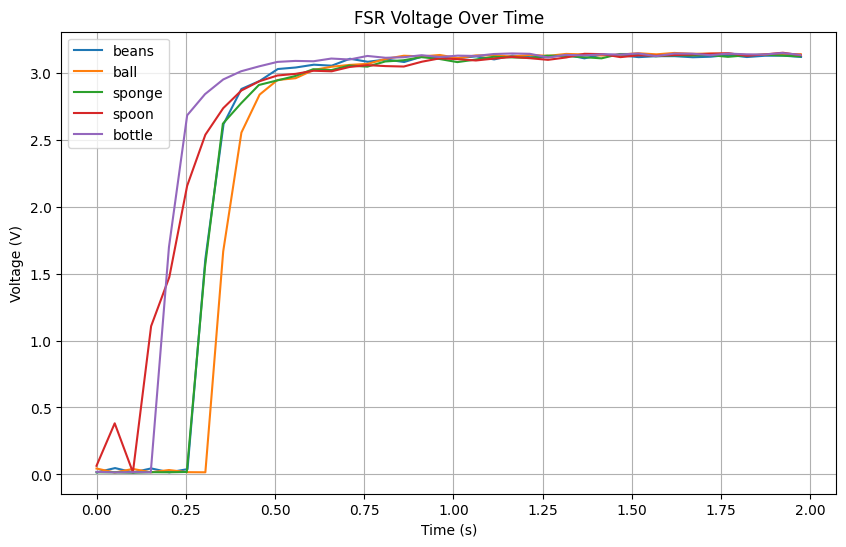

In [17]:
# Plot the curves for each object in the press data
plt.figure(figsize=(10, 6))
for object in objects:
    object_data = df_press[df_press['object'] == object]
    sns.lineplot(data=object_data, x='time_s', y='voltage', label=object)
plt.title('FSR Voltage Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.show()

The traces are broadly very similar across objects, with all reaching nearly the same steady-state voltage once fully pressed. Minor differences in the ramp-up phase, as well as the small spike at the start of one trial, are expected and likely due to normal human variation in the pressing motion. Overall, the steady-state output is consistent and largely object-independent.

### FSR Position Comparison
I performed a ‘long press’ of the DIGIT sensor on a tennis ball (chosen for its consistent texture and geometry) in several orientations to test whether the FSR’s angle affected the output. Specifically, I pressed downwards on the top of the ball, sideways on the right side, and upwards on the bottom, while holding the ball in my other hand to prevent movement.

In [18]:
# Load the CSV data
df_press_pos = pd.read_csv('data/press_position_data.csv')
df_press_pos.head()

,position,time_s,raw,voltage
0,top,0.000,320,0.0161
1,top,0.051,2464,0.1241
2,top,0.103,4177,0.2103
3,top,0.154,17636,0.8881
4,top,0.205,13747,0.6922


Temperature for calibration:  
Temperature:      24.0°C  
Humidity:         59%  

Notes:  
Remove outliers   
Average  
Convert to N  
Fit curve  
Run inference on new V and get for each threshold  

Cables not touching, placed in centre of scales